In [2]:
import numpy as np
from qiskit import *
from random import random, randint
import matplotlib.pyplot as plt

# import feature map
from feature_mapping_initialize_method import *

In [3]:
# Preparing feature-mapped circuit
# Inputs: 
#   num_qubits: number of qubits (log_2 of number of features), 
#   feature_data: data pertaining to each feature
# Outputs: 
#   qc: prepared quantum circuit
def prepare_circuit(num_qubits, feature_data):
    feature_data = normalize_data(feature_data)
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    qc.initialize(feature_data, qc.qubits)
    return qc

In [4]:
# Measures a quantum circuit and processes the output
# Inputs: 
#   circuit: quantum circuit
#   s: number of shots
# Outputs:
#   counts: dictionary of results from measuring the circuit
def process_output(circuit, s):
    
    arr = []

    simulator = Aer.get_backend('aer_simulator')

    job = execute(circuit, simulator, shots=s)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

# Classifies counts based on the parity of the bits
# Inputs:
#   counts: dictionary containing counts from the circuit
#   shots: number of shots used in measurement
# Outputs:
#   dictionary containing the probability distribution of the data falling into each class
def parity_probabilities(counts, shots=100):
    class_0 = 0
    class_1 = 0

    for keyBefore, value in counts.items():
        key = keyBefore.split()[0]
        temp = int(key[0]) ^ int(key[1])
        for i in range(2, len(key)):
            temp = temp ^ int(key[i])
        
        if temp == 0:
            class_0 += value
        else:
            class_1 += value
    return {0: class_0 / shots, 1: class_1 / shots}

# Performs a variational quantum circuit with arbitrary rotation gates
# Inputs:
#   register: quantum register for the qubits
#   angles: list of parameters to be applied with the rotation gates
#   qc: prepared quantum circuit
# Outputs:
#   parity_processed:
def rotation(num_qubits, angles, qc):

    measurement = ClassicalRegister(num_qubits)
    qc.add_register(measurement)
    for i in range(num_qubits): # adds rotation gates
        qc.ry(angles[i], i)
    
    for i in range(num_qubits - 1, 0, -1): # adds controlled X gates
        qc.cx(i, i - 1)

    qc.cx(0, num_qubits - 1)

    qc.measure_all()
    s = 100
    shots = process_output(qc, 100)
    
    parity_processed = parity_probabilities(shots) # processes with respect to parity
    return parity_processed

q = QuantumRegister(4)
initial_angles = [2 * np.pi * random() for _ in range(4)]
len(q)

4

In [5]:
# Calculates mean squared error 
# Inputs: 
#   shots_count: dictionary of probabilities
#   expected_value: either a 1 or a 0, corresponding to the data
# Outputs:
#   Mean squared error according to formula
def mse(shots_count, expected_value):
    probability_of_expected = shots_count[expected_value]
    return (1 - probability_of_expected) ** 2

# y_values are either 0, 1
# received_measurements are the dictionary of probabilities
def count_costs(x_values, y_values, angles, received_measurements):
    cost = 0

    for i in range(len(x_values)):
        cost += mse(received_measurements[i], y_values[i])
    
    return cost / len(x_values)
    

In [6]:
def cost_across_x(num_qubits, x, y, angles):
    measured = []
    for i in x:
        qc = prepare_circuit(num_qubits, i)
        measured.append(rotation(num_qubits, angles, qc))
    cost_count = count_costs(x, y, angles, measured)
    return cost_count

def optimize_angles(angles, cost, x_values, y_values, num_qubits, delta=0.3, learning_rate=0.7):
    new_angles = angles
    new_cost = cost
    partial_derivatives = []

    for i in range(len(angles)):
        step_up = [j for j in angles]
        step_up[i] += delta

        step_down = [j for j in angles]
        step_down[i] -= delta

        cost_up = cost_across_x(num_qubits, x_values, y_values, step_up)
        cost_down = cost_across_x(num_qubits, x_values, y_values, step_down)

        if cost_up < new_cost:
            new_cost = cost_up
            new_angles = [angle for angle in step_up]
        if cost_down < new_cost:
            new_cost = cost_down
            new_angles = [angle for angle in step_down]

    return new_angles, new_cost
        

In [7]:
from scipy.optimize import minimize
def train_naive(x, y, initial_angles, max_it=50):
    measured = []

    num_qubits = int(np.log2(len(x[0])))

    for i in range(len(x)):
        qc = prepare_circuit(num_qubits, x[i])
        measured.append(rotation(num_qubits, initial_angles, qc))
        
    cost = count_costs(x, y, initial_angles, measured)
    costs = [cost]
    angles = [initial_angles]

    print(f"initial parameters and costs: ({initial_angles}, {cost})")
    i = 0
    delta = 0.3

    while i < max_it:

        current_angles, current_cost = optimize_angles(angles[-1], costs[-1], x, y, num_qubits, delta=delta)

        # if current_cost == costs[-1]:
        #     delta += 0.2
        
        # if current_cost - costs[-1] >= 0.1 and delta >= 0.8:
        #     delta -= 0.2

        angles.append(current_angles)
        costs.append(current_cost)
        
        print(f"Iteration {i}: ({current_angles}, {current_cost})")
        
        i += 1


    print(f"Iteration {i}: ({angles[-1]}, {costs[-1]})")
    x_costs = [cost for cost in costs]
    y_axis = [i for i in range(len(x_costs))]

    plt.plot(y_axis, x_costs)
    index = x_costs.index(min(costs))
    return angles[index]

def train_library(x, y):
    num_qubits = int(np.log2(len(x[0])))
    initial_angles = [2 * np.pi * random() for _ in range(num_qubits)]
    optimized = minimize(lambda angles: cost_across_x(num_qubits, x, y, angles), initial_angles, method='COBYLA')
    return optimized, initial_angles

In [8]:
# Fitting to data

import preprocesstest as preprocess

features_train, features_test, target_train, target_test = preprocess.filter("Data/testHeart.csv")
type(target_train)
target_train =  [item for sublist in target_train for item in sublist]
target_test = [item for sublist in target_test for item in sublist]

Column: Sex has ['M' 'F'] unique values

Column: ExerciseAngina has ['N' 'Y'] unique values

Column: ChestPainType has ['ATA' 'NAP' 'ASY' 'TA'] unique values

Column: RestingECG has ['Normal' 'ST' 'LVH'] unique values

Column: ST_Slope has ['Up' 'Flat' 'Down'] unique values

features_train <class 'list'>
features_test <class 'list'>
target_train <class 'list'>
target_test <class 'list'>
Column: Sex has ['M' 'F'] unique values

Column: ExerciseAngina has ['N' 'Y'] unique values

Column: ChestPainType has ['ATA' 'NAP' 'ASY' 'TA'] unique values

Column: RestingECG has ['Normal' 'ST' 'LVH'] unique values

Column: ST_Slope has ['Up' 'Flat' 'Down'] unique values

features_train <class 'list'>
features_test <class 'list'>
target_train <class 'list'>
target_test <class 'list'>


initial parameters and costs: ([3.23567453571658, 1.8665221808567265], 0.2903095015576323)
Iteration 0: ([3.23567453571658, 2.1665221808567265], 0.2796792834890963)
Iteration 1: ([3.23567453571658, 2.4665221808567264], 0.2673169781931463)
Iteration 2: ([3.23567453571658, 2.766522180856726], 0.2566749221183802)
Iteration 3: ([3.23567453571658, 3.066522180856726], 0.25117492211837994)
Iteration 4: ([2.93567453571658, 3.066522180856726], 0.25099376947040497)
Iteration 5: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iteration 6: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iteration 7: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iteration 8: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iteration 9: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iteration 10: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iteration 11: ([2.6356745357165803, 3.066522180856726], 0.25082616822429893)
Iterat

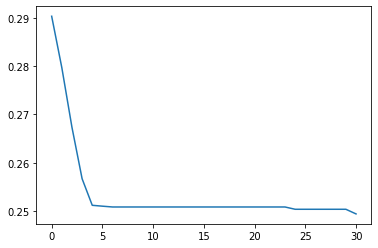

In [9]:
final_obj, initial_angles = train_library(features_train, target_train)
final_naive_array = train_naive(features_train, target_train, initial_angles, max_it=30)

In [18]:
# testing accuracy
final_array = final_obj.x.tolist()
def test_accuracy(x, y, optimized_params):
    measured = []

    num_qubits = int(np.log2(len(x[0])))
    for i in range(len(x)):
        qc = prepare_circuit(num_qubits, x[i])
        measured.append(rotation(num_qubits, initial_angles, qc))

    actual_measurements = []

    for i in measured:
        if i[0] > i[1]:
            actual_measurements.append(0)
        else:
            actual_measurements.append(1)

    count_correct = 0

    for i in range(len(y)):
        if y[i] == actual_measurements[i]:
            count_correct += 1
    
    return count_correct / len(y)

def find_final_angles(cost_array, angles_array):
    ind = cost_array.index((min(cost_array)))
    return angles_array[ind]

print("Scipy accuracy:", test_accuracy(features_train, target_train, final_array))
print("Naive approach accuracy:", test_accuracy(features_train, target_train, final_naive_array))
print("Initial angles accuracy:", test_accuracy(features_train, target_train, initial_angles))

Scipy accuracy: 0.4984423676012461
Naive approach accuracy: 0.5062305295950156
Initial angles accuracy: 0.5015576323987538


In [17]:
# Resource Estimation

from time import perf_counter
start = perf_counter()
angles = (np.pi, np.pi)
num_qubits = 2
qc = prepare_circuit(2, features_train[0])
measurement = ClassicalRegister(2)
qc.add_register(measurement)
for i in range(2): # adds rotation gates
    qc.ry(angles[i], i)

for i in range(num_qubits - 1, 0, -1): # adds controlled X gates
    qc.cx(i, i - 1)

qc.cx(0, num_qubits - 1)

qc.measure_all()
end = perf_counter()

time = end - start
depth = qc.depth()
print(qc)
depth

            ┌────────────────────────────────────────────────┐┌───────┐┌───┐»
q1052245_0: ┤0                                               ├┤ Ry(π) ├┤ X ├»
            │  Initialize(-0.65872,-0.11977,0.34328,0.65872) │├───────┤└─┬─┘»
q1052245_1: ┤1                                               ├┤ Ry(π) ├──■──»
            └────────────────────────────────────────────────┘└───────┘     »
  c95658: 2/════════════════════════════════════════════════════════════════»
                                                                            »
    meas: 2/════════════════════════════════════════════════════════════════»
                                                                            »
«                  ░ ┌─┐   
«q1052245_0: ──■───░─┤M├───
«            ┌─┴─┐ ░ └╥┘┌─┐
«q1052245_1: ┤ X ├─░──╫─┤M├
«            └───┘ ░  ║ └╥┘
«  c95658: 2/═════════╬══╬═
«                     ║  ║ 
«    meas: 2/═════════╩══╩═
«                     0  1 


5